In [1]:
#import pylas
import numpy as np
import laspy
import open3d as o3d

import matplotlib.pyplot as plt
import numpy as np
import cv2

from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny

from matplotlib import cm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
las.header
las.header.point_format
las.header.point_count
las.vlrs

[<ExtraBytesVlr(extra bytes structs: 4)>, <laspy.vlrs.known.WktCoordinateSystemVlr object at 0x000001DE7B3CE7C0>, <VLR(user_id: 'liblas', record_id: '2112', data len: 905)>]

In [22]:
list(las.point_format.dimension_names)

['X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'synthetic',
 'key_point',
 'withheld',
 'overlap',
 'scanner_channel',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'user_data',
 'scan_angle',
 'point_source_id',
 'gps_time',
 'red',
 'green',
 'blue',
 'ClassFlags',
 'Amplitude',
 'Reflectance',
 'Deviation']

In [23]:
las.classification

array([2, 2, 2, ..., 2, 2, 2], dtype=uint8)

In [33]:
point_data = np.stack([las.X, las.Y, las.Z], axis=0).transpose((1, 0))
point_data.shape

(17708868, 3)

In [41]:
distanceXperKM = (np.max(point_data[:,0]) - np.min(point_data[:,0]))
distanceXperM = distanceXperKM/1000
distanceXperCM = distanceXperM/100

print("1 x distance per KM: ", distanceXperKM)
print("1 x distance per M: ", distanceXperM)
print("1 x distance per CM: ", distanceXperCM)

print()

distanceYperKM = (np.max(point_data[:,1]) - np.min(point_data[:,1]))
distanceYperM = distanceYperKM/1000
distanceYperCM = distanceYperM/100

print("1 y distance per KM: ", distanceYperKM)
print("1 y distance per M: ", distanceYperM)
print("1 y distance per CM: ", distanceYperCM)

(np.max(point_data[:,2]) - np.min(point_data[:,2]))

1 x distance per KM:  100000
1 x distance per M:  100.0
1 x distance per CM:  1.0

1 y distance per KM:  100000
1 y distance per M:  100.0
1 y distance per CM:  1.0


9089

In [9]:
f = open("testFile.txt", "a")
for i in range(point_data.shape[0]):
    f.write(str(point_data[i,0]) + "," + str(point_data[i, 1]) + "," + str(point_data[i, 2]) + "\n")
f.close()

In [7]:
point_data

array([[ 52200026, 607994082,      3183],
       [ 52200054, 607994083,      3182],
       [ 52200085, 607994083,      3181],
       ...,
       [ 52293791, 607907120,      3401],
       [ 52293761, 607907119,      3398],
       [ 52293743, 607907149,      3402]])

In [8]:
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(point_data)
o3d.visualization.draw_geometries([geom])





In [18]:
# Seperate the classes from set(list(las.classification))

print(set(list(las.classification)))

buildings = laspy.create(point_format=las.header.point_format, file_version=las.header.version)
buildings.points = las.points[las.classification == 6]
buildings.write('buildings.las')




#two.write('two.las')

{2, 3, 4, 5, 6, 7, 8, 9, 18}


In [30]:
powerlines = laspy.create(point_format=las.header.point_format, file_version=las.header.version)
powerlines.points = las.points[las.classification == 5]

point_data = np.stack([powerlines.X, powerlines.Y, powerlines.Z], axis=0).transpose((1, 0))
print(point_data.shape)


geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(point_data)
o3d.visualization.draw_geometries([geom])

(5863951, 3)


In [28]:
las = laspy.read(r'/home/frederik/data/denmark/raw/val/PUNKTSKY_00005_1km_6090_507.laz')

powerlines = laspy.create(point_format=las.header.point_format, file_version=las.header.version)
powerlines.points = las.points[las.classification == 14]

point_data_powerlines = np.stack([powerlines.X, powerlines.Y, powerlines.Z], axis=0).transpose((1, 0))
print(point_data_powerlines.shape)

point_data_all = np.stack([las.X, las.Y, las.Z], axis=0).transpose((1, 0))


    
#geom = o3d.geometry.PointCloud()
#geom.points = o3d.utility.Vector3dVector(point_data)
#o3d.visualization.draw_geometries([geom])

(5209, 3)


In [61]:
# Create Dictionary
dictio = {}
counter = 0
for coordinate in point_data_all:
    x, y, z = coordinate
    
    #round x and y to the nearest center.
    meter=0.2
    rounded = 100*meter
    
    center_x = np.round(x/rounded)*rounded
    center_y = np.round(y/rounded)*rounded
    
    if (center_x, center_y) in dictio:
        dictio[(center_x, center_y)].append([x, y, z])
    else:
        dictio[(center_x, center_y)] = [[x, y, z]]


        final_coordinates = []
        
for value in dictio.values():
    numpy_arr_value = np.array(value)
    z_values = numpy_arr_value[:,2]

    # Get the heights and difference
    max_height = np.max(z_values)
    min_height = np.min(z_values)
    difference = max_height-min_height
    
    # meters in Z value
    meter = 3
    meter_criterion = meter*100
    
    # Set the minimum height criterion
    minimum_height = min_height+meter_criterion
    
    # check is there are points higher than the specified meters from the ground.
    if difference > meter_criterion:
        
        # For each coord, append if the coord is higher than 4 meters.
        for coord in numpy_arr_value:
            x, y, z = coord
            if z >= minimum_height:
                final_coordinates.append(coord)
                counter += 1
                
final_coordinates = np.array(final_coordinates)

In [63]:

geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(final_coordinates)
o3d.visualization.draw_geometries([geom])






In [62]:
final_coordinates.shape[0] - 5863951

-2911866

In [54]:
final_coordinates.shape[0] - 5863951

-1218857

In [7]:
counter = 0
lst = []
for key in dictio.keys():
    # The list of Z values
    value = dictio[key]
    
    # Get the heights and difference
    max_height = np.max(value)
    min_height = np.min(value)
    difference = max_height-min_height
    
    # 4 meters in Z value
    meter_criterion = 300
    
    # check is there are points higher than 4 meters from the ground
    if difference > meter_criterion:
        x, y = key
        for z_val in value:
            
            minimum_height = min_height+meter_criterion
            if z_val >= minimum_height:
                lst.append([x, y, z_val])
                counter += 1
    if counter % 200 == 0:
        print(counter)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
20

600
600
600
600
600
600
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800


1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400
1400


2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200
2200


2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600
2600


2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800


3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200
3200


4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000


4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200


4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200
4200


4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800


5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000


5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5200
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5400
5600
5600
5600
5600
5600
5600
5600
5600
5600
5600
5600
5600
5600
5600
5600
5800
5800
5800


6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000


7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400
7400


8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000
8000


8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200


8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200


8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200
8200


8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400


8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400
8400


In [9]:
lst = np.array(lst)

In [10]:
lst.shape

(8578, 3)

In [14]:
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(lst)
o3d.visualization.draw_geometries([geom])

In [29]:
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(point_data_all)
o3d.visualization.draw_geometries([geom])

In [ ]:
las = laspy.read(r'/home/frederik/data/TestData/meters.las')
point_data = np.stack([las.X, las.Y, las.Z], axis=0).transpose((1, 0))
print(point_data.shape)


geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(point_data)
o3d.visualization.draw_geometries([geom])

(6597487, 3)


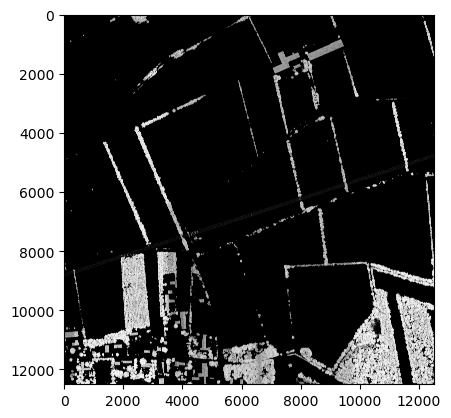

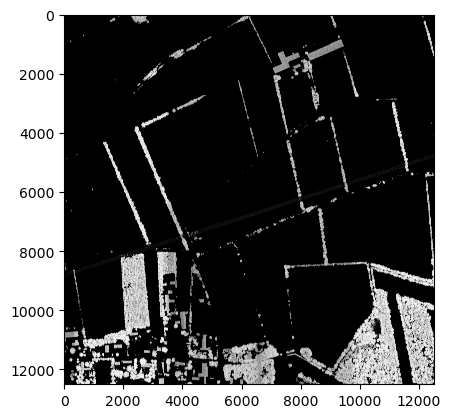

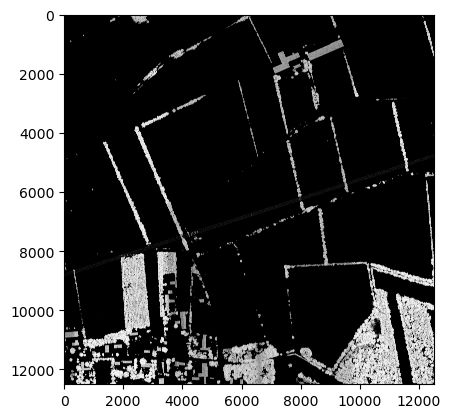

In [4]:
img = cv2.imread('/home/frederik/data/TestData/meters_idw.tif', cv2.IMREAD_UNCHANGED)
plt.imshow(img, cmap='gray')
plt.show()

img = cv2.imread('/home/frederik/data/TestData/meters_min.tif', cv2.IMREAD_UNCHANGED)
plt.imshow(img, cmap='gray')
plt.show()

img = cv2.imread('/home/frederik/data/TestData/meters_max.tif', cv2.IMREAD_UNCHANGED)
plt.imshow(img, cmap='gray')
plt.show()

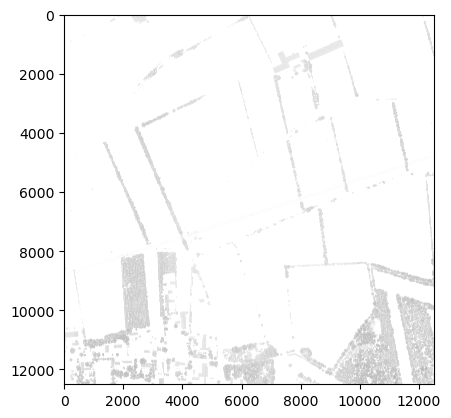

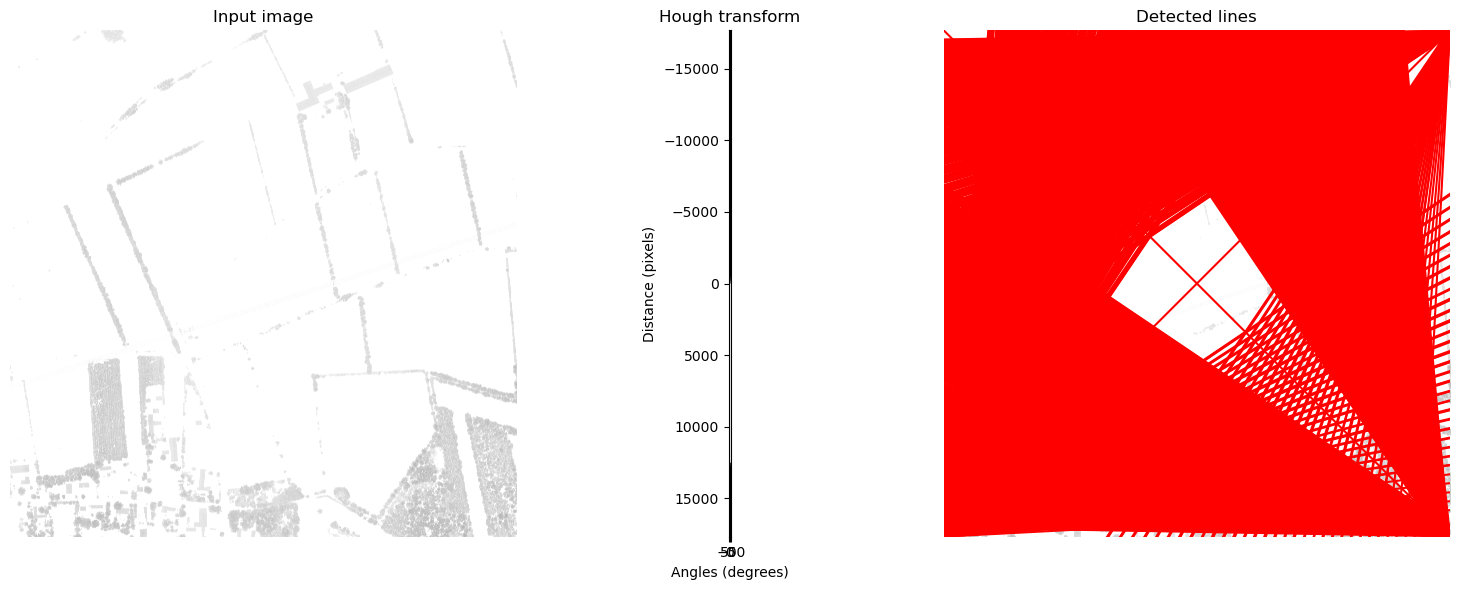

In [7]:
image = cv2.imread('/home/frederik/data/TestData/meters_max.tif', cv2.IMREAD_UNCHANGED)
image = np.where(image >= 0, image, 0)
image = image/np.max(image)
#image = 1-image

plt.imshow(image, cmap='gray')
plt.show()

# Classic straight-line Hough transform
h, theta, d = hough_line(image)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, image.shape[1]), (y0, y1), '-r')
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

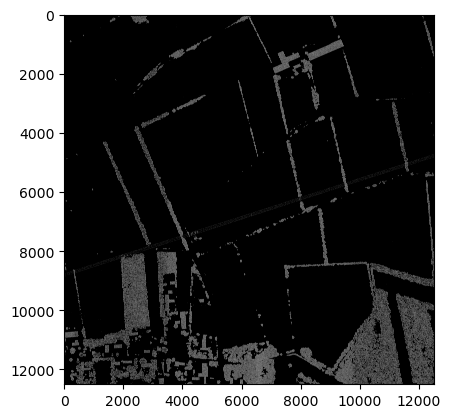

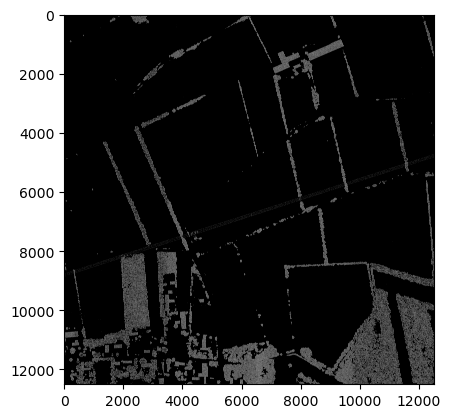

3053


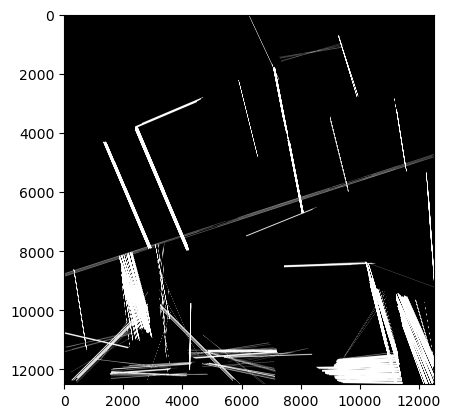

In [52]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

image = cv2.imread('/home/frederik/data/TestData/meters_max.tif', cv2.IMREAD_UNCHANGED)
image = np.where(image >= 0, image, 0)
image = image/np.max(image)

#image = mpimg.imread("test_images/ppnt.jpg")
image = (image*255).astype(np.uint8)

plt.imshow(edges, cmap='gray')
plt.show()


# Apply edge detection method on the image
#edges = cv2.Canny(image, 50, 200, None, 3)
edges = cv2.Canny(image, 50, 50, None, 3)

plt.imshow(edges, cmap='gray')
plt.show()


# Probabilistic Line Transform
# min_line_length, max_line_gap
linesP = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, None, 2000, 200)
#linesP = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, None, 300, 10)

print(len(linesP))

lines_image = np.zeros_like(image)

# Draw the lines
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(lines_image, (l[0], l[1]), (l[2], l[3]), (255,0,0), 3)


plt.imshow(lines_image, cmap='gray')
plt.show()

(12501, 12501)

In [3]:
las = laspy.read(r'/home/frederik/data/TestData/meters.las')
point_data = np.stack([las.X, las.Y, las.Z], axis=0).transpose((1, 0))



In [9]:
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(point_data)
o3d.visualization.draw_geometries([geom])

In [15]:


# Create Dictionary
dictio = {}
for i, coordinate in enumerate(point_data):
    x, y, z = coordinate
    #round x and y and z to the nearest center.
    meter = 2
    rounded = 100*meter
    
    center_x = np.round(x/rounded)*rounded
    center_y = np.round(y/rounded)*rounded
    center_z = np.round(z/rounded)*rounded
    
    if (center_x, center_y, center_z) in dictio:
        dictio[(center_x, center_y, center_z)].append([x,y,z])
    else:
        dictio[(center_x, center_y, center_z)] = [[x,y,z]]






In [10]:
limit = 10
final_array = []
for value in dictio.values():
    if len(value) <= limit:
        final_array += value
        
final_array = np.array(final_array)

In [14]:
#geom = o3d.geometry.PointCloud()
#geom.points = o3d.utility.Vector3dVector(final_array)
#o3d.visualization.draw_geometries([geom])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(final_array)
o3d.visualization.draw_geometries([pcd])

In [11]:
print(point_data.shape)
print(final_array.shape)

(6597487, 3)
(144703, 3)


In [ ]:
def LoadAndDataProcess(filename):
    with open(filename) as f:
        lines = [line.rstrip('\n') for line in f]
    f.close()
    lst = []
    for i in lines:
        splitted = i.split(',')
        lst.append(splitted[0][8:])
        lst.append(splitted[1][4:])
        lst.append(splitted[2])
        lst.append(splitted[3][:-1])
        lst.append(splitted[4][4:])
        lst.append(splitted[5])
        lst.append(splitted[6][:-1])
    lst = np.array(lst, dtype=float).reshape(-1, 7)
    return lst

# nlines, coordinate a, coordinate b
LoadAndDataProcess("Hough10Lines.txt")